In [125]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)


import altair as alt
alt.data_transformers.disable_max_rows()

import glob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import act
import pyart
import xarray as xr
import os

In [126]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

# Identify datastreams

In [127]:
# ppi:  Single-pass full-360o plan position indicator scan 
# ppi2: Single- or multi-pass full or limited sector plan position indicator scan 
# rhi:  Single-pass full-180o range height indicator scan 
# rhi2: Single- or multi-pass full or limited sector range height indicator scan
ds_dl_ppi = 'gucdlppiM1.b1'
ds_dl_rhi = 'gucdlrhiM1.b1'
ds_dl_rhi2 = 'gucdlrhi2M1.b1'

startdate = '2022-10-31'
enddate = '2022-11-04'

# Download datasets

In [197]:


act.discovery.download_data(username, token, 'dlprofwind4news', startdate, enddate)

No files returned or url status error.
Check datastream name, start, and end date.


[]

In [128]:
act.discovery.download_data(username, token, ds_dl_ppi, startdate, enddate)
act.discovery.download_data(username, token, ds_dl_rhi, startdate, enddate)
act.discovery.download_data(username, token, ds_dl_rhi2, startdate, enddate)

[DOWNLOADING] gucdlppiM1.b1.20221101.231503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.000021.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.001503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.081502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.101502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.103003.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.104503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.130022.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.143003.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.144503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.150021.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.151502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.153003.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.154502.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.164503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.180022.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.183003.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.004503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.020022.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.021503.cdf
[DOWNLOADING] gucdlppiM1.b1.20221102.023

[]

In [129]:
dl_ppi_files = glob.glob(''.join(['./',ds_dl_ppi,'/*cdf']))
dl_rhi_files = glob.glob(''.join(['./',ds_dl_rhi,'/*cdf']))
dl_rhi2_files = glob.glob(''.join(['./',ds_dl_rhi2,'/*cdf']))

In [130]:
dl_rhi = act.io.armfiles.read_netcdf(dl_rhi_files)

In [131]:
dl_ppi = act.io.armfiles.read_netcdf(dl_ppi_files)


Reading RHI2 scans with act library fails because there are no RHI2 scans

In [29]:
dl_rhi2 = act.io.armfiles.read_netcdf(dl_rhi2_files)

OSError: no files to open

# Examine RHI data

In [132]:
src_rhi = dl_rhi.to_dataframe().reset_index()

In [133]:
(
    len(src_rhi['time'].unique()), 
    len(src_rhi['range'].unique()), 
    len(src_rhi['elevation'].unique()), 
    len(src_rhi['azimuth'].unique())
)

(34837, 400, 13229, 2)

43561 timestamps over multiple days  (based on our query)

400 discrete range values

13866 discrete elevation angles

2 azimuth directions (0, 270)

In [138]:
(
    src_rhi['time'].unique(), 
    src_rhi['range'].unique(), 
    src_rhi['elevation'].unique(), 
    src_rhi['azimuth'].unique()
)

(array(['2022-10-31T00:01:18.959000000', '2022-10-31T00:01:20.120000000',
        '2022-10-31T00:01:21.139000000', ...,
        '2022-11-03T23:07:35.781000000', '2022-11-03T23:07:36.790000000',
        '2022-11-03T23:07:37.930000000'], dtype='datetime64[ns]'),
 array([   15.,    45.,    75.,   105.,   135.,   165.,   195.,   225.,
          255.,   285.,   315.,   345.,   375.,   405.,   435.,   465.,
          495.,   525.,   555.,   585.,   615.,   645.,   675.,   705.,
          735.,   765.,   795.,   825.,   855.,   885.,   915.,   945.,
          975.,  1005.,  1035.,  1065.,  1095.,  1125.,  1155.,  1185.,
         1215.,  1245.,  1275.,  1305.,  1335.,  1365.,  1395.,  1425.,
         1455.,  1485.,  1515.,  1545.,  1575.,  1605.,  1635.,  1665.,
         1695.,  1725.,  1755.,  1785.,  1815.,  1845.,  1875.,  1905.,
         1935.,  1965.,  1995.,  2025.,  2055.,  2085.,  2115.,  2145.,
         2175.,  2205.,  2235.,  2265.,  2295.,  2325.,  2355.,  2385.,
         2415.,  24

## RHI: convert polar coordinates to rectangular coords with the radar at (0,0)

In [139]:
src_rhi['x'] = src_rhi['range']*np.cos(np.deg2rad(src_rhi['elevation']))
src_rhi['z'] = src_rhi['range']*np.sin(np.deg2rad(src_rhi['elevation']))

## Plot hourly RHI scans (azimuth == 0)

In [140]:
src_rhi['date'] = src_rhi['time'].dt.date

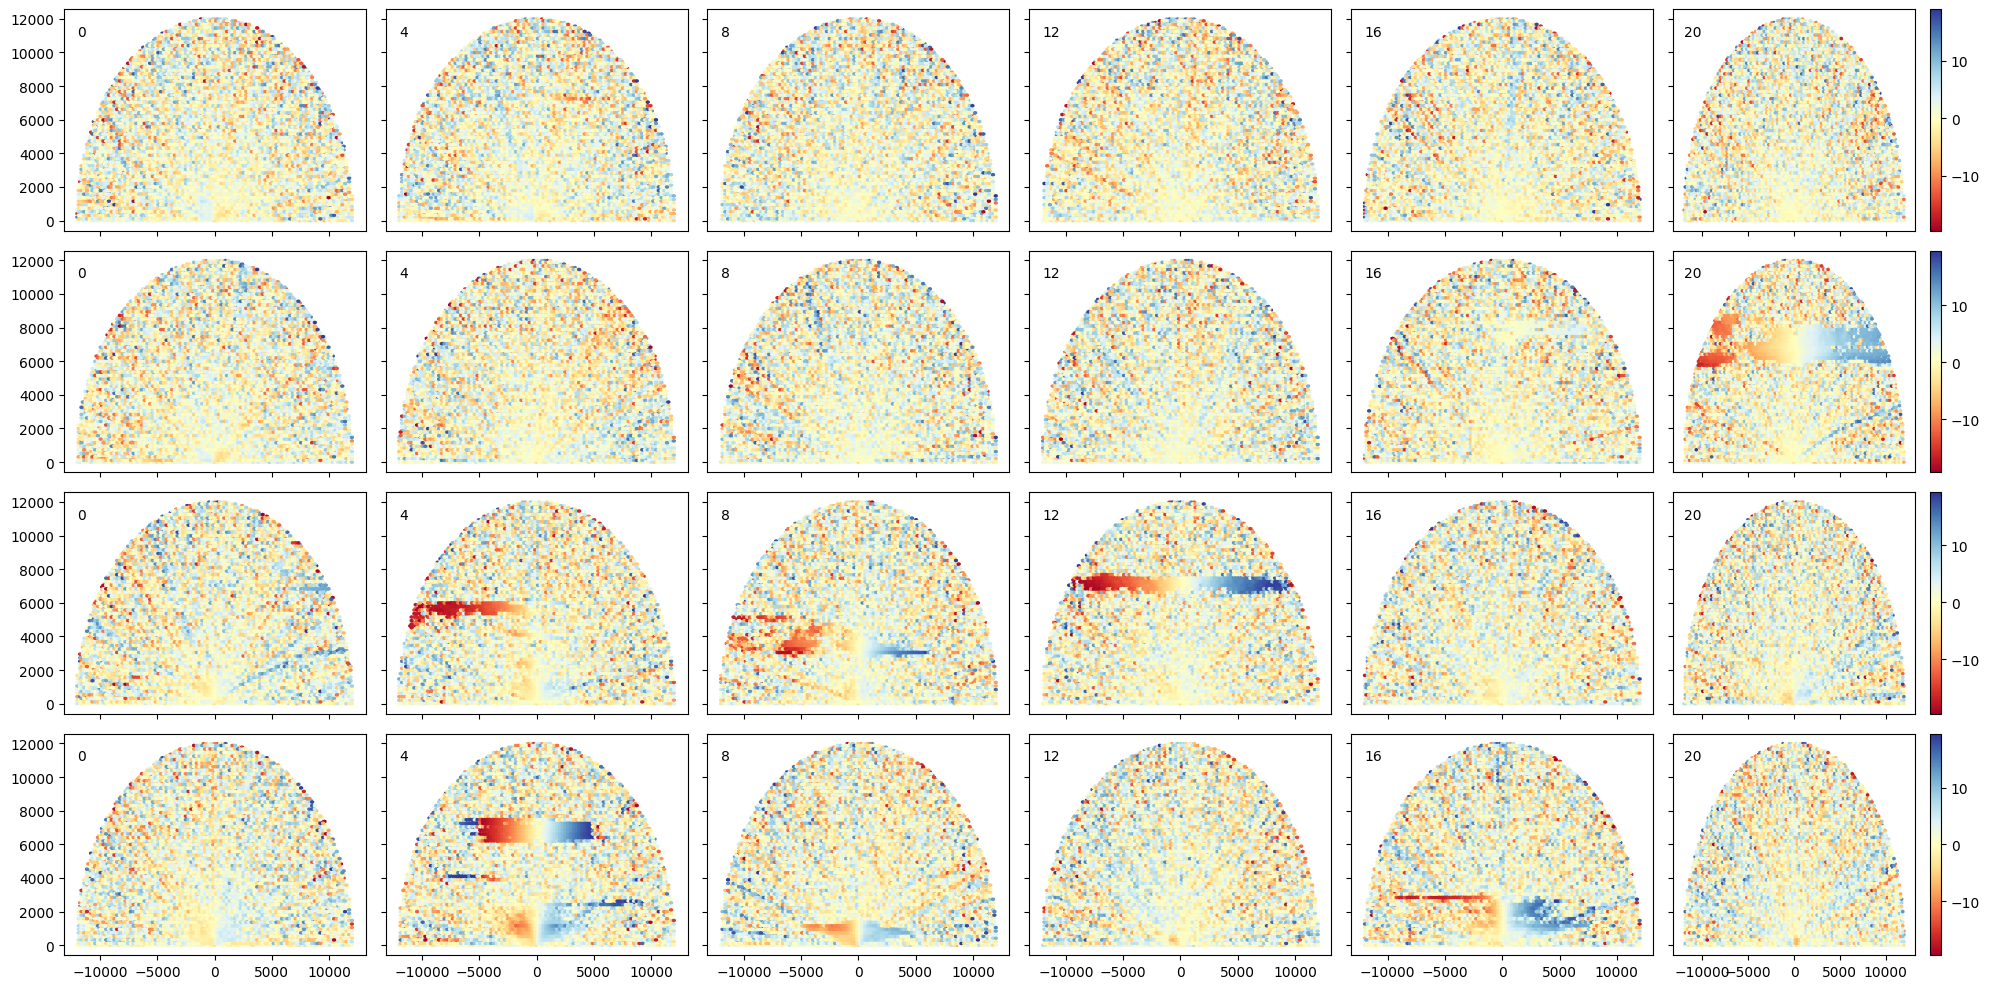

In [141]:
src = src_rhi[src_rhi['azimuth'] == 0]

plot_hours = [0,4,8,12,16,20]
plot_days = sorted(src_rhi['date'].unique())

fig, axes = plt.subplots(
    len(src_rhi['date'].unique()), 
    len(plot_hours), 
    figsize=(20,10), 
    sharex=True, sharey=True
)

for i_day, day in enumerate(plot_days):
    for i,hr in enumerate(plot_hours):
        local_src = src[ (src['date'] == day) & (src['time'].dt.hour == hr)]
        ax = axes[i_day][i]
        hexplot = ax.hexbin(local_src['x'], local_src['z'], C=local_src['radial_velocity'], cmap='RdYlBu')
        ax.annotate(str(hr), xy=(-12000, 11000))
    plt.tight_layout()
    plt.colorbar(hexplot)

## Plot hourly RHI scans (azimuth == 270)

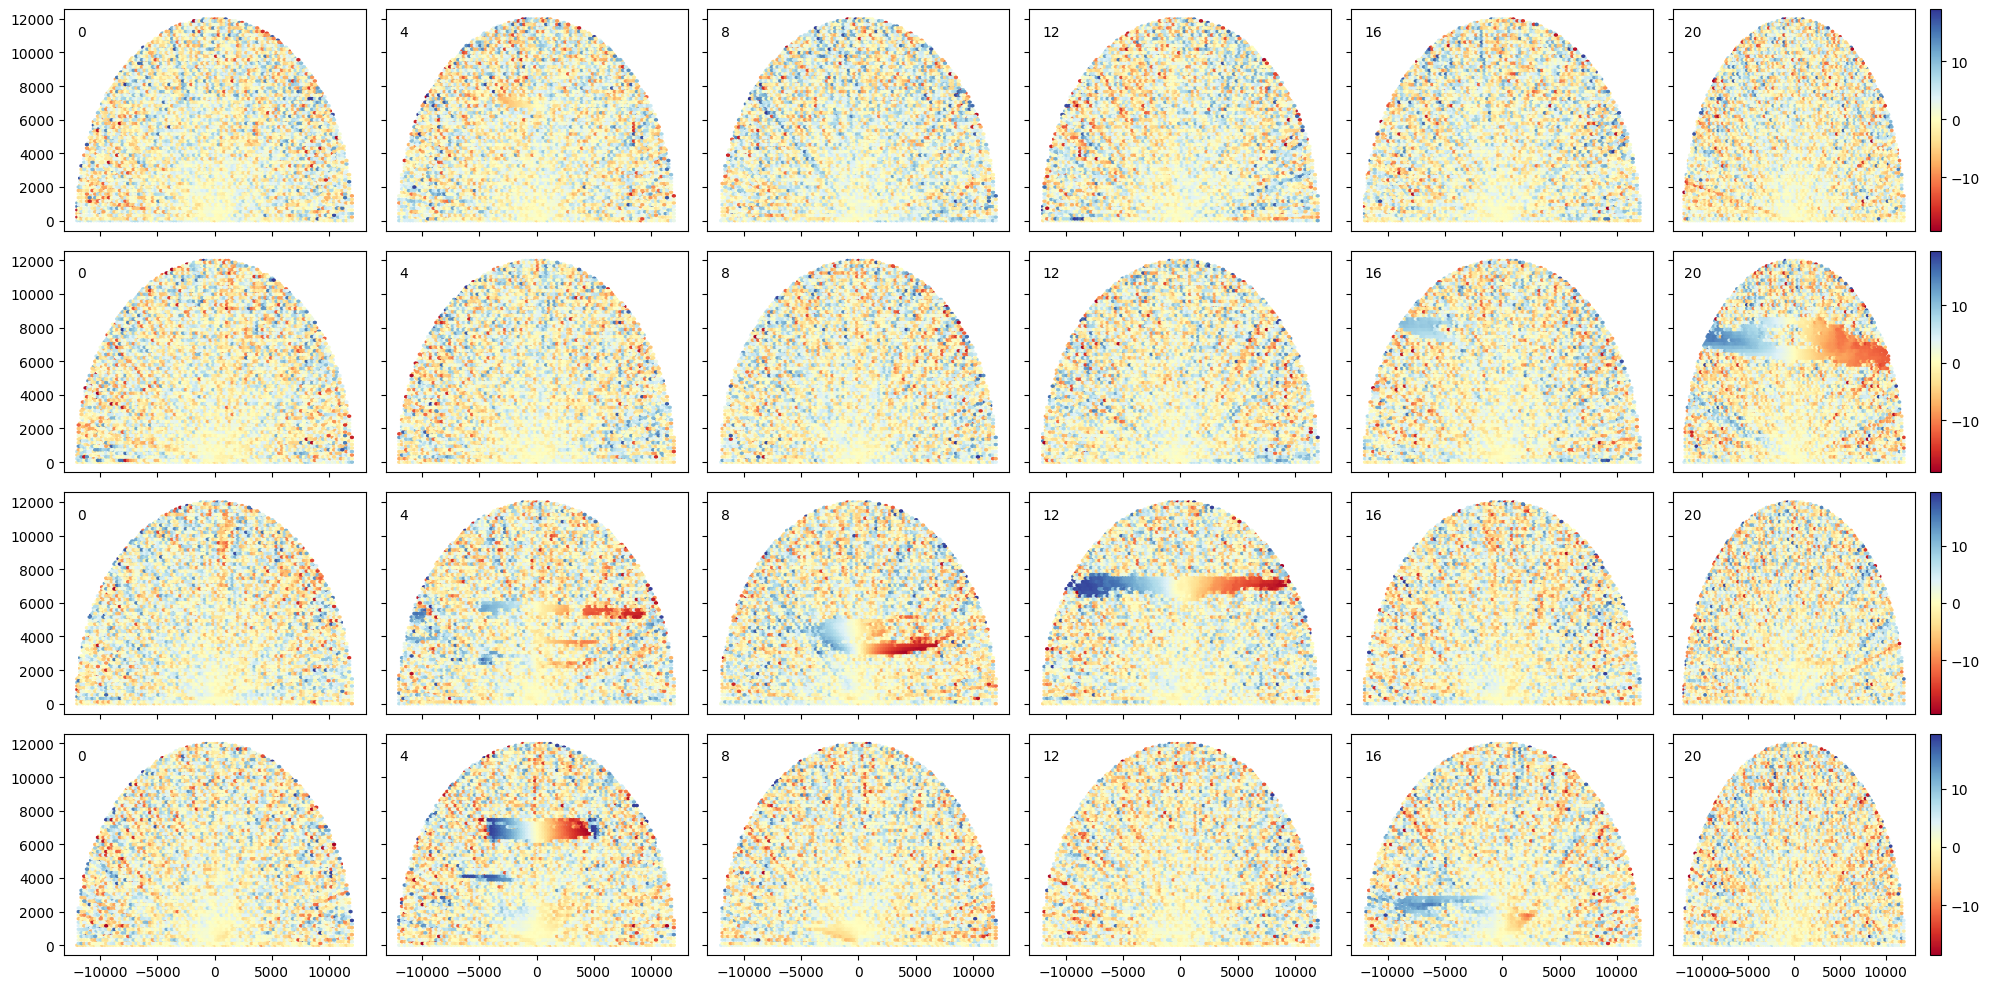

In [142]:
src = src_rhi[src_rhi['azimuth'] == 270]

plot_hours = [0,4,8,12,16,20]
plot_days = sorted(src_rhi['date'].unique())

fig, axes = plt.subplots(
    len(src_rhi['date'].unique()), 
    len(plot_hours), 
    figsize=(20,10), 
    sharex=True, sharey=True
)

for i_day, day in enumerate(plot_days):
    for i,hr in enumerate(plot_hours):
        local_src = src[ (src['date'] == day) & (src['time'].dt.hour == hr)]
        ax = axes[i_day][i]
        hexplot = ax.hexbin(local_src['x'], local_src['z'], C=local_src['radial_velocity'], cmap='RdYlBu')
        ax.annotate(str(hr), xy=(-12000, 11000))
    plt.tight_layout()
    plt.colorbar(hexplot)

# Examine PPI data

## By using xarray DIRECTLY

In [146]:
dl_ppi_files[:5], dl_ppi_files[-5:]

(['./gucdlppiM1.b1/gucdlppiM1.b1.20221031.000022.cdf',
  './gucdlppiM1.b1/gucdlppiM1.b1.20221031.001503.cdf',
  './gucdlppiM1.b1/gucdlppiM1.b1.20221031.003003.cdf',
  './gucdlppiM1.b1/gucdlppiM1.b1.20221031.004502.cdf',
  './gucdlppiM1.b1/gucdlppiM1.b1.20221031.010022.cdf'],
 ['./gucdlppiM1.b1/gucdlppiM1.b1.20221103.224503.cdf',
  './gucdlppiM1.b1/gucdlppiM1.b1.20221103.230022.cdf',
  './gucdlppiM1.b1/gucdlppiM1.b1.20221103.231502.cdf',
  './gucdlppiM1.b1/gucdlppiM1.b1.20221103.233002.cdf',
  './gucdlppiM1.b1/gucdlppiM1.b1.20221103.234503.cdf'])

In [117]:
df = xr.open_dataset(dl_ppi_files[0]).to_dataframe().reset_index()

In [144]:
dl_ppi.time.max(), dl_ppi.time.min()

(<xarray.DataArray 'time' ()>
 array('2022-11-03T23:45:39.179000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()>
 array('2022-10-31T00:00:22.460000000', dtype='datetime64[ns]'))

## By using the ACT library to compute vertical wind profiles

In [ ]:
len(dl_ppi[dict(range=slice(0, 2))].to_dataframe()), len(dl_ppi.to_dataframe())

6144

### Limit range values so that computing winds doesn't take so long

In [177]:
dl_ppi_slice = dl_ppi[dict(range=slice(0, 4))].sel(
    time=slice(datetime.datetime(2022,11,2,4), datetime.datetime(2022,11,2,16))
)

In [182]:
# Calculate the winds from the gucdlppi dataset.
wind_obj_sliced = act.retrievals.compute_winds_from_ppi(
    dl_ppi_slice,
    remove_all_missing=True, 
    snr_threshold=0.002
)

In [183]:
wind_obj_sliced.to_dataframe()

wind_speed  wind_direction  \
time                       height                                  
2022-11-02 04:00:39.880000 14.095389         NaN             NaN   
                           42.286167    0.571300      158.022276   
                           70.476944    1.410074      328.952547   
                           98.667725    0.772092       65.835178   
2022-11-02 04:15:21.355000 14.095389    0.051594       11.600048   
                           42.286167    0.286136      258.540154   
                           70.476944    0.339172       94.093053   
                           98.667725    1.244682      158.186135   
2022-11-02 04:30:20.894500 14.095389    0.075792      126.700814   
                           42.286167    0.640452      308.793638   
                           70.476944    1.114167        7.709459   
                           98.667725    1.468400       92.104215   
2022-11-02 04:45:21.175000 14.095389    0.032416       48.752098   
                           42.286167    0.389339      164.979692   
                           70.476944    2.043304        2.127781   
                           98.667725    0.643830      335.126049   
2022-11-02 05:00:39.715000 14.095389    0.068527      178.860581   
                           42.286167    0.399499      265.474185   
                           70.476944    0.529725      312.091675   
                           98.667725    0.861244      334.620033   
2022-11-02 05:15:20.644000 14.095389    0.115543       38.158866   
                           42.286167    0.190983      142.600928   
                           70.476944    1.777401      151.361486   
                           98.667725    2.513403      147.835594   
2022-11-02 05:30:21.134500 14.095389    0.027995      124.099880   
                           42.286167    0.195925      328.975268   
                           70.476944    1.111164      216.065755   
                           98.667725    0.565066      161.957410   
2022-11-02 05:45:21.470000 14.095389    0.110585        3.725260   
                           42.286167    0.376895      305.858817   
                           70.476944    0.942764       77.229549   
                           98.667725    0.881367      121.126186   
2022-11-02 06:00:40.395000 14.095389    0.048363      268.835638   
                           42.286167    0.142842       67.031799   
                           70.476944    1.179355       79.333774   
                           98.667725    0.911469      103.845416   
2022-11-02 06:15:21.180000 14.095389    0.059896      206.252366   
                           42.286167    0.427246      124.544265   
                           70.476944    1.312228      336.959146   
                           98.667725    0.580767      177.684426   
2022-11-02 06:30:21.459500 14.095389    0.083799      278.526123   
                           42.286167    0.228498      331.036927   
                           70.476944    1.701947      339.470393   
                           98.667725    1.532268      343.976510   
2022-11-02 06:45:21.474500 14.095389    0.057163      292.373765   
                           42.286167    6.724125      350.487297   
                           70.476944    1.410230      354.114092   
                           98.667725    1.077597      344.641617   
2022-11-02 07:00:39.974000 14.095389    0.058127      185.390474   
                           42.286167    0.381233      291.398885   
                           70.476944    0.523585       11.596946   
                           98.667725    0.915506      353.412018   
2022-11-02 07:15:20.989500 14.095389    0.073060      281.631034   
                           42.286167    0.321333      155.863966   
                           70.476944    0.504885      357.099224   
                           98.667725    0.108525       43.873727   
2022-11-02 07:30:20.924500 14.095389    0.115440      308.162510   
                          

In [194]:
alt.Chart(
    wind_obj_sliced.to_dataframe().reset_index()
).mark_point(shape="wedge", filled=True).encode(
    alt.X('time:T'),
    alt.Y('height:Q'),
    # color=alt.Color(
    #     "wind direction", scale=alt.Scale(domain=[0, 360], scheme="rainbow"), legend=None
    # ),
    angle=alt.Angle("wind_direction", scale=alt.Scale(domain=[0, 360], range=[180, 540])),
    size=alt.Size("wind_speed", scale=alt.Scale(rangeMax=2000, rangeMin=250), title='Wind Speed (m/s)'),
).properties(
    width=1000,
    height=200
)

/Users/elischwat/miniconda3/envs/arm/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [187]:
(
    alt.Chart(
        wind_obj_sliced.to_dataframe().reset_index()
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('wind_direction:Q', title='Wind Direction'),
        alt.Color('height:N')
    ).properties(width=1000, height=200)
&
    alt.Chart(
        wind_obj_sliced.to_dataframe().reset_index()
    ).transform_window(
        rolling_mean='mean(wind_direction)',
        frame=[-4, 4],
        groupby=['height']
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('rolling_mean:Q'),
        alt.Color('height:N')
    ).properties(width=1000, height=200)
)

/Users/elischwat/miniconda3/envs/arm/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

### For all range values

In [51]:
# Calculate the winds from the gucdlppi dataset.
wind_obj = act.retrievals.compute_winds_from_ppi(
    dl_ppi, remove_all_missing=True, snr_threshold=0.002)

In [61]:
ppi_calc_winds_df = wind_obj.to_dataframe()

In [73]:
src = ppi_calc_winds_df.query("height < 100")

In [114]:
alt.Chart(src.reset_index()).transform_window(
    rolling_mean='mean(wind_direction)',
    frame=[-4, 4],
    groupby=['height']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('rolling_mean:Q'),
    alt.Color('height:N')
).properties(width=1000)


/Users/elischwat/miniconda3/envs/arm/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [74]:
alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('time:T'),
    alt.Y('wind_direction'),
    alt.Color('height:N')
).properties(width=1400)

/Users/elischwat/miniconda3/envs/arm/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

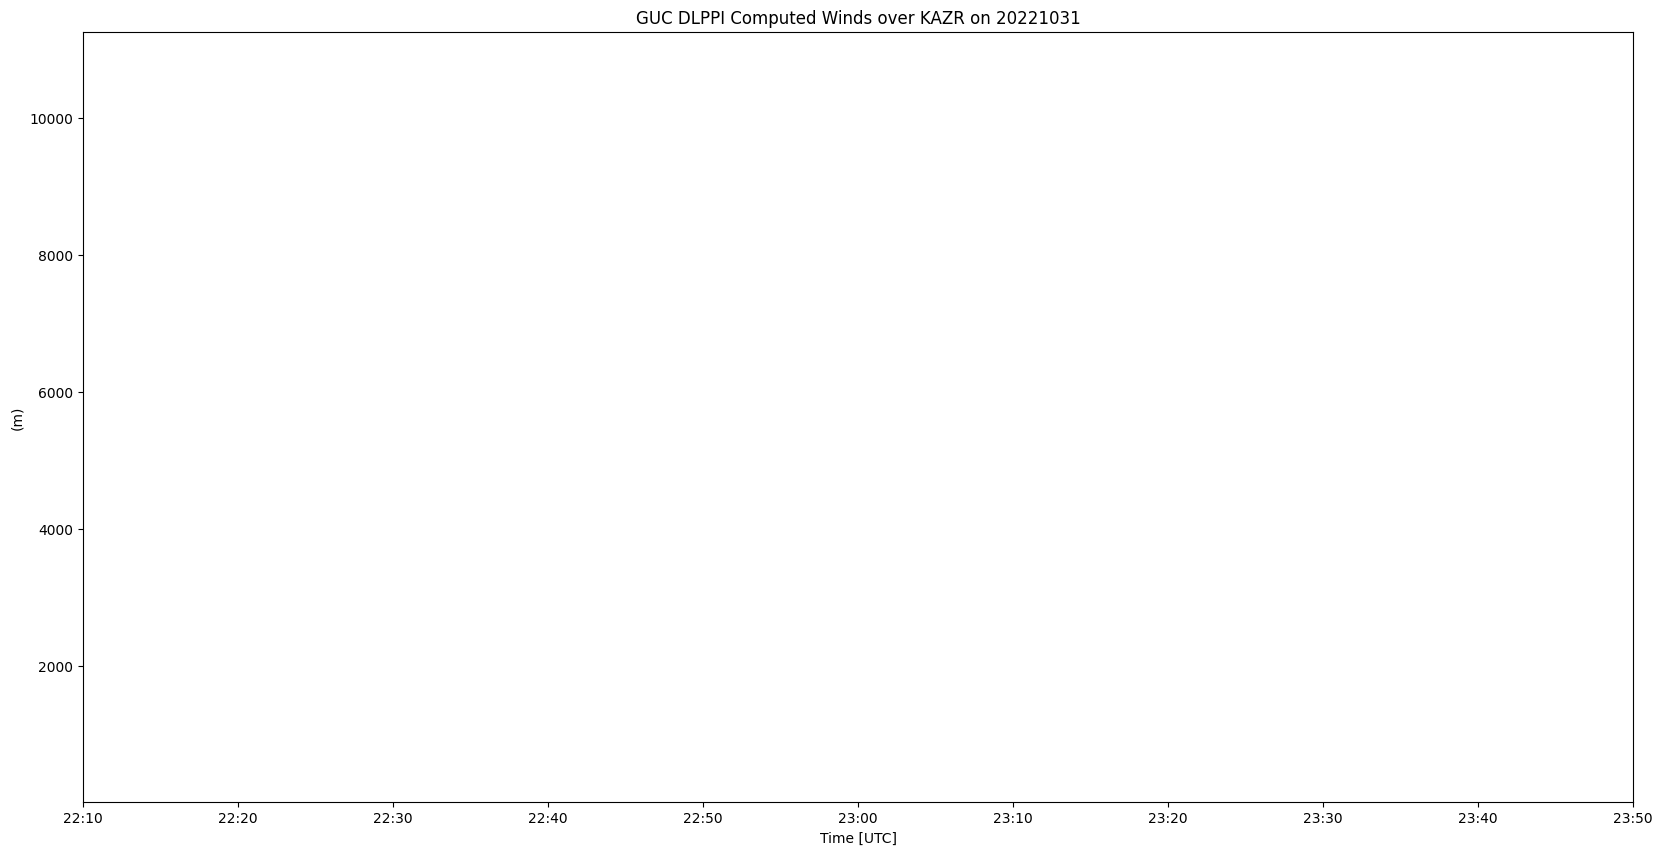

In [60]:
# Create a display object.
display = act.plotting.TimeSeriesDisplay(
    {"GUC DLPPI Computed Winds over KAZR": wind_obj,
     }, figsize=(20, 10))

display.plot_barbs_from_spd_dir('wind_speed', 'wind_direction',
                                dsname='GUC DLPPI Computed Winds over KAZR',
                                invert_y_axis=False)

# Update the x-limits to make sure both wind profiles are shown
display.axes[0].set_xlim([np.datetime64('2022-08-01T22:10'), np.datetime64('2022-08-01T23:50')])
plt.show()

In [56]:
(
    len(ppi_calc_winds_df['time'].unique()), 
    len(ppi_calc_winds_df['height'].unique()), 
),(
    ppi_calc_winds_df['time'].unique(), 
    ppi_calc_winds_df['height'].unique(), 
)

((192, 400),
 (array(['2022-10-31T00:00:40.415000000', '2022-10-31T00:15:21.385000000',
         '2022-10-31T00:30:21.029500000', '2022-10-31T00:45:20.829500000',
         '2022-10-31T01:00:40.074500000', '2022-10-31T01:15:21.429500000',
         '2022-10-31T01:30:20.964500000', '2022-10-31T01:45:21.505000000',
         '2022-10-31T02:00:39.864500000', '2022-10-31T02:15:21.079500000',
         '2022-10-31T02:30:20.824500000', '2022-10-31T02:45:20.730000000',
         '2022-10-31T03:00:40.589000000', '2022-10-31T03:15:20.719000000',
         '2022-10-31T03:30:21.414500000', '2022-10-31T03:45:20.879500000',
         '2022-10-31T04:00:40.074000000', '2022-10-31T04:15:21.120000000',
         '2022-10-31T04:30:21.274500000', '2022-10-31T04:45:21.289500000',
         '2022-10-31T05:00:40.389500000', '2022-10-31T05:15:20.509500000',
         '2022-10-31T05:30:21.049500000', '2022-10-31T05:45:21.350000000',
         '2022-10-31T06:00:40.584500000', '2022-10-31T06:15:20.714000000',
         '20

8 timestamps over ~36 seconds, every ~5 seconds

400 discrete range values

1 elevation angle

8 azimuth directions (259.1, 304.1, 349.1,  34.100006,  79.100006, 124.100006, 169.09998 , 214.09998)

In [42]:
(
    len(df['time'].unique()), 
    len(df['range'].unique()), 
    len(df['elevation'].unique()), 
    len(df['azimuth'].unique())
),(
    df['time'].unique(), 
    df['range'].unique(), 
    df['elevation'].unique(), 
    df['azimuth'].unique()
)

((8, 400, 1, 8),
 (array(['2022-10-31T00:00:22.460002000', '2022-10-31T00:00:27.640008000',
         '2022-10-31T00:00:32.770010999', '2022-10-31T00:00:37.889999000',
         '2022-10-31T00:00:43.009994000', '2022-10-31T00:00:48.129985000',
         '2022-10-31T00:00:53.250015000', '2022-10-31T00:00:58.370002000'],
        dtype='datetime64[ns]'),
  array([   15.,    45.,    75.,   105.,   135.,   165.,   195.,   225.,
           255.,   285.,   315.,   345.,   375.,   405.,   435.,   465.,
           495.,   525.,   555.,   585.,   615.,   645.,   675.,   705.,
           735.,   765.,   795.,   825.,   855.,   885.,   915.,   945.,
           975.,  1005.,  1035.,  1065.,  1095.,  1125.,  1155.,  1185.,
          1215.,  1245.,  1275.,  1305.,  1335.,  1365.,  1395.,  1425.,
          1455.,  1485.,  1515.,  1545.,  1575.,  1605.,  1635.,  1665.,
          1695.,  1725.,  1755.,  1785.,  1815.,  1845.,  1875.,  1905.,
          1935.,  1965.,  1995.,  2025.,  2055.,  2085.,  2115., 

In [43]:
df['azimuth'].unique()

array([259.1     , 304.1     , 349.1     ,  34.100006,  79.100006,
       124.100006, 169.09998 , 214.09998 ], dtype=float32)

# Look at XPrecip radar data, PPI

In [44]:
df2 = xr.open_dataset('/Users/elischwat/Downloads/gucxprecipradarS2.00.20221030.000005.raw.nc/gucxprecipradarS2.00.20221030.000130.raw.csu.sail-20221030-000130_702887_22_1_PPI.nc').to_dataframe()

from 

https://cookbooks.projectpythia.org/radar-cookbook/notebooks/foundations/pyart-gridding.html

In [45]:
radar = pyart.io.read('/Users/elischwat/Downloads/gucxprecipradarS2.00.20221030.000005.raw.nc/gucxprecipradarS2.00.20221030.000130.raw.csu.sail-20221030-000130_702887_22_1_PPI.nc')
print(radar.scan_type)

ppi


In [46]:
fig = plt.figure(figsize=[10, 10])
display = pyart.graph.RadarMapDisplay(radar)
radar.fields.keys()

dict_keys(['DBZ', 'VEL', 'WIDTH', 'ZDR', 'PHIDP', 'RHOHV', 'NCP', 'SNR', 'DBZhv'])

<Figure size 1000x1000 with 0 Axes>

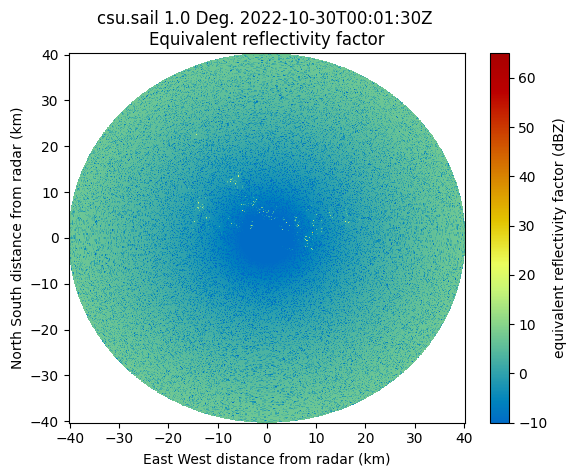

In [47]:
display.plot_ppi('DBZ')

# Look at XPrecip radar data, RHI

In [48]:
# Explore files

radar = pyart.io.read('/Users/elischwat/Downloads/gucxprecipradarS2.00.20221030.000005.raw.nc/gucxprecipradarS2.00.20221030.000005.raw.csu.sail-20221030-000005_702875_22_326_RHI.nc')
print(radar.scan_type)

fig = plt.figure(figsize=[10, 10])
display = pyart.graph.RadarMapDisplay(radar)
radar.fields.keys()

rhi


dict_keys(['DBZ', 'VEL', 'WIDTH', 'ZDR', 'PHIDP', 'RHOHV', 'NCP', 'SNR', 'DBZhv'])

<Figure size 1000x1000 with 0 Axes>

/Users/elischwat/miniconda3/envs/arm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


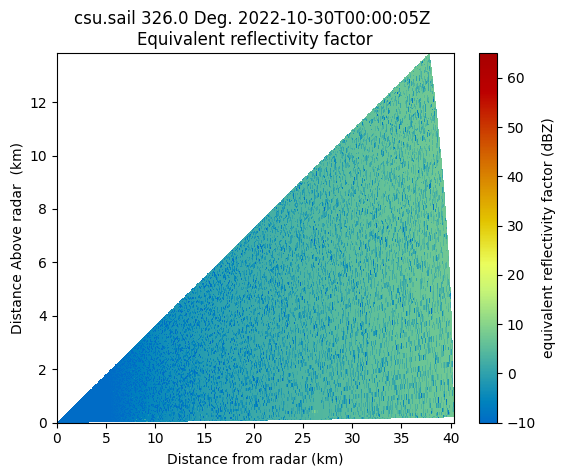

In [49]:
display.plot_rhi('DBZ')